# USA Mega Million Lottery Prediction

Building a model to predict lottery outcomes is inherently challenging due to the game's random nature. However, for analytical and comparative purposes, you can explore various models to identify patterns or trends in historical data. Here's a structured approach:
1. Data Collection:
    Historical Draw Data
    Additional Features: Incorporate metadata such as draw dates, days of the week, and jackpot amounts to enrich your dataset.
2. Model Selection:
    a. Frequency Analysis: Calculate the frequency of each number's occurrence in past draws to identify "hot" (frequently drawn) and "cold" (infrequently drawn) numbers.
    b. Logistic Regression: A statistical model that estimates the probability of a binary outcome, such as whether a specific number will appear in a draw.
    c. Random Forest Classifier: An ensemble learning method that constructs multiple decision trees to improve classification accuracy.

For data preparation, we need to collect the history data from official website such as the number of draws since each number last appeared, moving averages, or the standard deviation of drawn numbers. Then we need to divide the dataset into training and testing sets to evaluate model performance. For model evaluation, we used accuracy, precision, recall, and the F1-score to assess classification models.  Implement k-fold cross-validation to ensure model robustness.

Ethical Considerations:
cknowledge that lottery draws are designed to be random, and no model can reliably predict outcomes. Use analyses for educational or entertainment purposes, not for gambling strategies.

### Loading data

In [48]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from collections import Counter

In [66]:
# Load the dataset
file_path = './data_cleaned.csv' 
lottery_data = pd.read_csv(file_path)

# Display dataset info
print(lottery_data.info())
print(lottery_data.describe())

# Extract main ball and mega ball numbers
main_balls = lottery_data.iloc[:, 2:7].values.flatten()
main_balls = pd.to_numeric(main_balls, errors='coerce')  # Ensure numeric values
main_balls = main_balls[~pd.isnull(main_balls)]  # Remove NaNs

mega_ball = lottery_data.iloc[:, 7]
mega_ball = pd.to_numeric(mega_ball, errors='coerce')  # Ensure numeric values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3 non-null      float64
 1   Unnamed: 1  210 non-null    object 
 2   Main ball1  210 non-null    int64  
 3   Main ball2  210 non-null    int64  
 4   Main ball3  210 non-null    int64  
 5   Main ball4  210 non-null    int64  
 6   Main ball5  210 non-null    int64  
 7   Mega ball   210 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 13.2+ KB
None
       Unnamed: 0  Main ball1  Main ball2  Main ball3  Main ball4  Main ball5  \
count         3.0  210.000000  210.000000  210.000000  210.000000  210.000000   
mean       2023.0   11.414286   23.333333   34.985714   47.171429   58.890476   
std           1.0    8.896792   12.114025   12.711551   12.339656   10.148298   
min        2022.0    1.000000    2.000000    6.000000   15.000000   18.000000   
25%        20

### EDA

In [61]:
# Calculate the frequency of each number for main balls
main_ball_freq = pd.Series(main_balls).value_counts().reindex(range(1, 71), fill_value=0)
print("\nMain Ball Frequencies:")
print(main_ball_freq)

mega_ball_freq = pd.Series(mega_ball).value_counts().reindex(range(1, 26), fill_value=0)
print("\nMega Ball Frequencies:")
print(mega_ball_freq)


Main Ball Frequencies:
1     14
2     15
3     26
4     10
5     15
      ..
66    25
67    13
68    10
69    17
70    14
Name: count, Length: 70, dtype: int64

Mega Ball Frequencies:
Mega ball
1      9
2      6
3     11
4     12
5      5
6      5
7     11
8      8
9      9
10     2
11    14
12     8
13    10
14     8
15     5
16     5
17     9
18    12
19     9
20     8
21     8
22     7
23     5
24    13
25    11
Name: count, dtype: int64


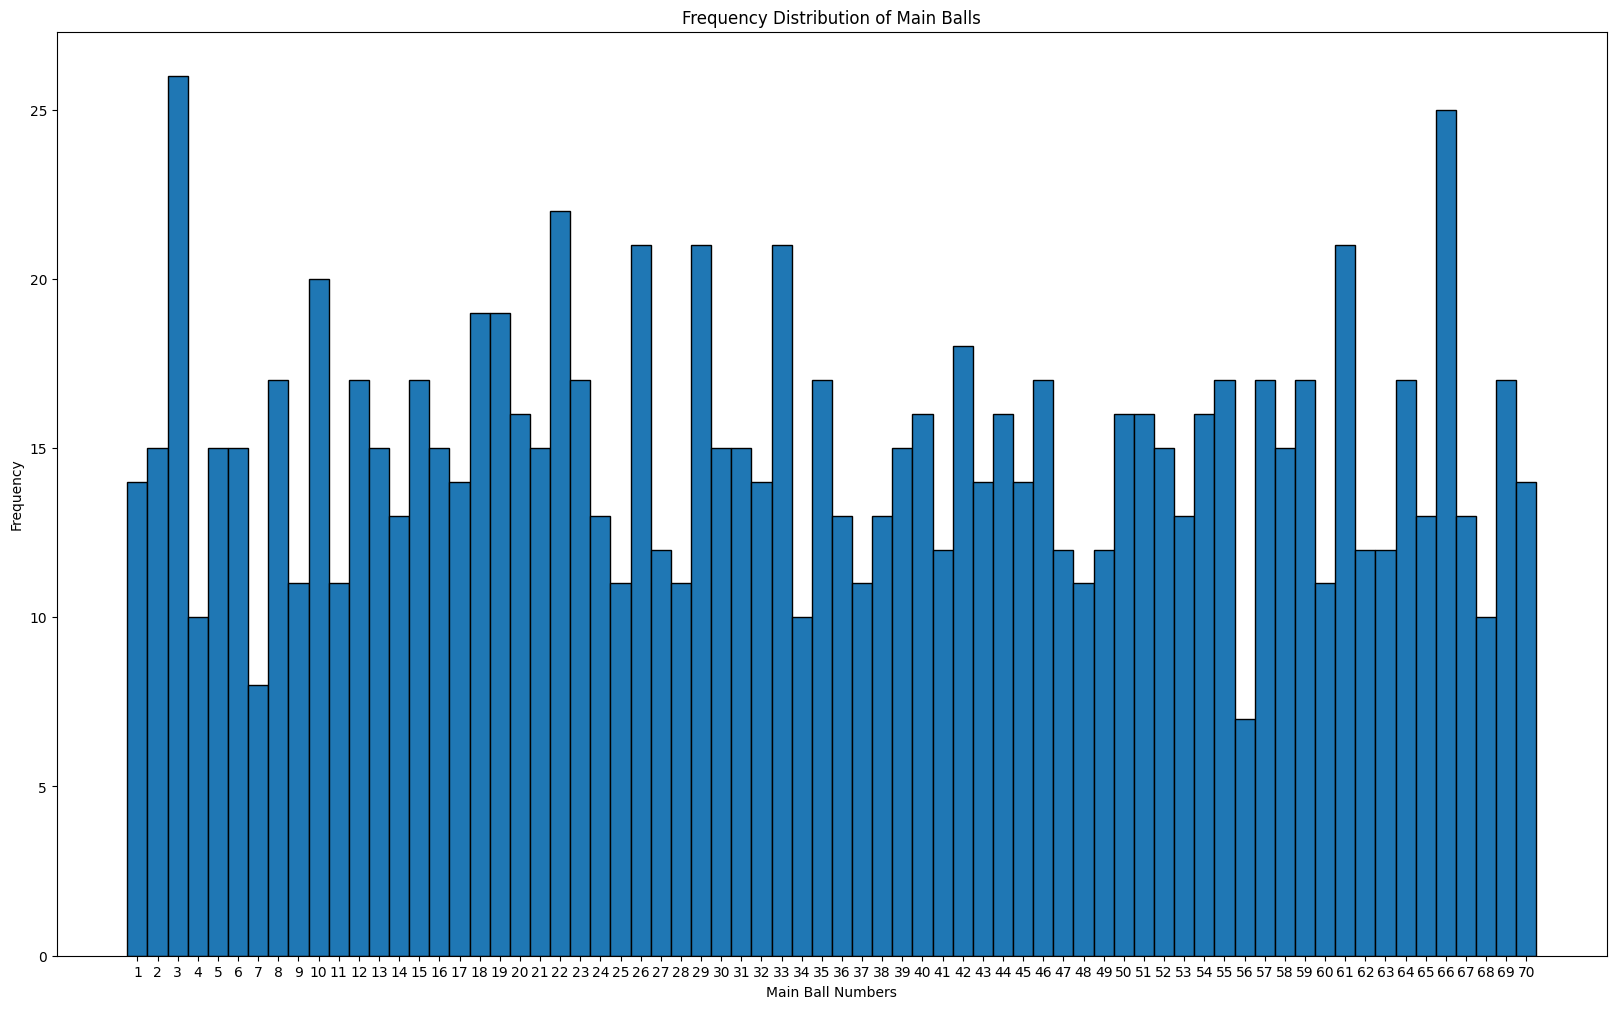

In [62]:
# Plotting frequency distribution of main balls with each number in xlabels
plt.figure(figsize=(20, 12))
plt.hist(main_balls, bins=range(1, 72), align="left", edgecolor="black")
plt.title("Frequency Distribution of Main Balls")
plt.xlabel("Main Ball Numbers")
plt.ylabel("Frequency")
plt.xticks(range(1, 71))  # Set x-axis labels to show each number
plt.show()

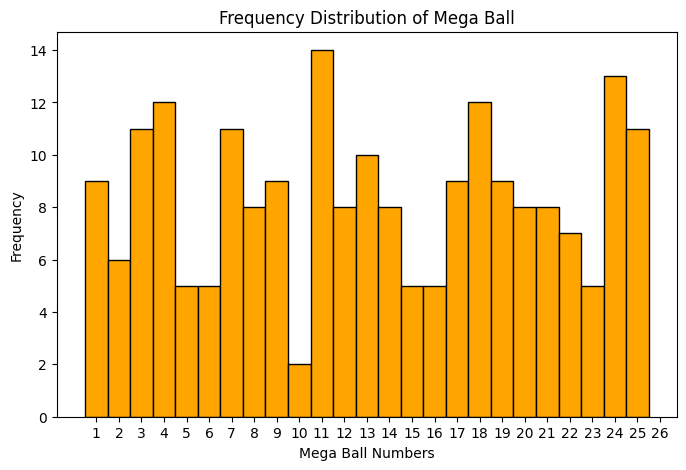

In [64]:
# Plotting frequency distribution of mega ball
plt.figure(figsize=(8, 5))
plt.hist(mega_ball, bins=range(1, 27), align="left", edgecolor="black", color='orange')
plt.title("Frequency Distribution of Mega Ball")
plt.xlabel("Mega Ball Numbers")
plt.ylabel("Frequency")
plt.xticks(range(1, 27))  # Set x-axis labels to show each number
plt.show()

In [65]:
# Check correlation between main balls and mega ball
numeric_columns = lottery_data.select_dtypes(include=[np.number])
correlation = numeric_columns.corr()
print("\nCorrelation Matrix:")
print(correlation)


Correlation Matrix:
            Unnamed: 0  Main ball1  Main ball2  Main ball3  Main ball4  \
Unnamed: 0    1.000000    0.904194    0.457804    0.777714    0.211604   
Main ball1    0.904194    1.000000    0.619263    0.490063    0.394517   
Main ball2    0.457804    0.619263    1.000000    0.726925    0.520871   
Main ball3    0.777714    0.490063    0.726925    1.000000    0.700807   
Main ball4    0.211604    0.394517    0.520871    0.700807    1.000000   
Main ball5    0.046761    0.231983    0.335204    0.447632    0.622372   
Mega ball     0.949653    0.095610    0.065266    0.039607    0.008549   

            Main ball5  Mega ball  
Unnamed: 0    0.046761   0.949653  
Main ball1    0.231983   0.095610  
Main ball2    0.335204   0.065266  
Main ball3    0.447632   0.039607  
Main ball4    0.622372   0.008549  
Main ball5    1.000000   0.007671  
Mega ball     0.007671   1.000000  


In [53]:
print("\nMost Frequent Main Ball Numbers:")
print(main_ball_freq.sort_values(ascending=False).head(10))

print("\nMost Frequent Mega Ball Numbers:")
print(mega_ball_freq.sort_values(ascending=False).head(10))


Most Frequent Main Ball Numbers:
3     26
66    25
22    22
61    21
33    21
29    21
26    21
10    20
19    19
18    19
Name: count, dtype: int64

Most Frequent Mega Ball Numbers:
Mega ball
11    14
24    13
4     12
18    12
25    11
3     11
7     11
13    10
9      9
19     9
Name: count, dtype: int64


In [54]:
combination_counts = Counter()
for row in main_balls.reshape(-1, 5):  # Reshape to ensure each row has 5 elements
    row_combinations = combinations(sorted(row), 2)  # Get pairs (change 2 to other values for larger combinations)
    combination_counts.update(row_combinations)
    
most_frequent_combinations = combination_counts.most_common(10)
print("\nMost Frequent Main Ball Combinations:")
for combo, count in most_frequent_combinations:
    print(f"Combination {combo} appeared {count} times")



Most Frequent Main Ball Combinations:
Combination (10, 66) appeared 6 times
Combination (18, 64) appeared 5 times
Combination (28, 69) appeared 5 times
Combination (26, 36) appeared 5 times
Combination (3, 19) appeared 5 times
Combination (15, 32) appeared 5 times
Combination (3, 29) appeared 4 times
Combination (39, 42) appeared 4 times
Combination (31, 64) appeared 4 times
Combination (29, 46) appeared 4 times


In [55]:
combination_counts = Counter()
for row in main_balls.reshape(-1, 5):  # Reshape to ensure each row has 5 elements
    row_combinations = combinations(sorted(row), 3)  # Get pairs (change 2 to other values for larger combinations)
    combination_counts.update(row_combinations)
    
most_frequent_combinations = combination_counts.most_common(10)
print("\nMost Frequent Main Ball Combinations:")
for combo, count in most_frequent_combinations:
    print(f"Combination {combo} appeared {count} times")


Most Frequent Main Ball Combinations:
Combination (3, 22, 66) appeared 3 times
Combination (3, 46, 63) appeared 3 times
Combination (21, 39, 45) appeared 2 times
Combination (5, 22, 24) appeared 2 times
Combination (13, 20, 32) appeared 2 times
Combination (13, 26, 32) appeared 2 times
Combination (13, 26, 65) appeared 2 times
Combination (13, 32, 65) appeared 2 times
Combination (26, 32, 65) appeared 2 times
Combination (25, 28, 69) appeared 2 times


## Preprocessing

In [68]:
# Flatten main ball numbers and prepare input for frequency-based models
main_balls_flat = main_balls.flatten()
main_balls_flat = pd.to_numeric(main_balls_flat, errors='coerce')  # Ensure numeric
main_balls_flat = main_balls_flat[~pd.isnull(main_balls_flat)]

In [70]:
# Convert main_balls to DataFrame
main_balls_df = pd.DataFrame(main_balls, columns=['Main_Ball'])

# Combine main balls and mega ball for LSTM/GRU
data_combined = pd.concat([main_balls_df, mega_ball.reset_index(drop=True)], axis=1)

In [73]:
from sklearn.model_selection import train_test_split

# Split data for main balls
main_train, main_test = train_test_split(main_balls, test_size=0.2, shuffle=False, random_state=42)
main_train, main_val = train_test_split(main_train, test_size=0.2, shuffle=False, random_state=42)

# Split data for mega ball
mega_train, mega_test = train_test_split(mega_ball, test_size=0.2, shuffle=False, random_state=42)
mega_train, mega_val = train_test_split(mega_train, test_size=0.2, shuffle=False, random_state=42)

# Print dataset sizes
print(f"Main Balls - Training: {len(main_train)}, Validation: {len(main_val)}, Test: {len(main_test)}")
print(f"Mega Ball - Training: {len(mega_train)}, Validation: {len(mega_val)}, Test: {len(mega_test)}")

Main Balls - Training: 672, Validation: 168, Test: 210
Mega Ball - Training: 134, Validation: 34, Test: 42


### Markov Chain

In [115]:
from collections import defaultdict

# Create a Markov Chain transition matrix
transition_matrix = defaultdict(lambda: defaultdict(int))

# Convert main_train to DataFrame
main_train_df = pd.DataFrame(main_train)

# Build the transition matrix using training data
for row in main_train_df.values:
    sorted_row = sorted(row)  # Sort the row to handle unordered main balls
    for i in range(len(sorted_row)):
        for j in range(i + 1, len(sorted_row)):  # Consider all pairs in the row
            transition_matrix[sorted_row[i]][sorted_row[j]] += 1
            transition_matrix[sorted_row[j]][sorted_row[i]] += 1  # Backward transition

# Normalize the transition matrix to probabilities
for current_num in transition_matrix:
    total_transitions = sum(transition_matrix[current_num].values())
    for next_num in transition_matrix[current_num]:
        transition_matrix[current_num][next_num] /= total_transitions

# Predict the next number based on the current number
def predict_next_markov(chain, current_num, weighted=True):
    if current_num in chain:
        if weighted:
            # Weighted sampling based on probabilities
            next_nums, probs = zip(*chain[current_num].items())
            return np.random.choice(next_nums, p=probs)
        else:
            # Predict the most probable next number
            return max(chain[current_num], key=chain[current_num].get)
    return np.random.randint(1, 71)  # Random fallback for unseen numbers

# Function to predict a full set of 5 main balls
def predict_main_balls(chain):
    predicted_balls = []
    current_num = np.random.randint(1, 71)  # Start with a random number
    while len(predicted_balls) < 5:
        next_num = predict_next_markov(chain, current_num)
        if next_num not in predicted_balls:  # Avoid duplicate predictions
            predicted_balls.append(next_num)
        current_num = next_num
    return sorted(predicted_balls)

# Function to predict the mega ball
def predict_mega_ball():
    return np.random.randint(1, 26)  # Mega ball is a random number between 1 and 25

# Generate predictions
predicted_main_balls = predict_main_balls(transition_matrix)
predicted_mega_ball = predict_mega_ball()

# Display the prediction
print("Predicted Lottery Numbers:")
print(f"Main Balls: {predicted_main_balls}")
print(f"Mega Ball: {predicted_mega_ball}")


Predicted Lottery Numbers:
Main Balls: [5, 42, 45, 49, 60]
Mega Ball: 15


In [129]:
# Ensure the array size is consistent with rows of 5 for main balls
main_val_array = np.array(main_val)
main_val_array = main_val_array[: (len(main_val_array) // 5) * 5]  # Ensure length is a multiple of 5
main_val_array = main_val_array.reshape(-1, 5)  # Reshape to rows of 5 main balls

# Adjust the length of main_val_array to match the length of mega_val
if len(main_val_array) > len(mega_val):
    main_val_array = main_val_array[:len(mega_val)]
elif len(main_val_array) < len(mega_val):
    mega_val = mega_val.iloc[:len(main_val_array)]

# Validate lengths of main balls and mega balls in the validation set
if len(main_val_array) != len(mega_val):
    raise ValueError("Mismatch between number of main ball rows and mega ball entries in validation set.")

hit_rates = []  # Count of matching main balls per draw
mega_ball_hits = []  # Count of matching mega balls
combination_matches = []  # Check for full combination matches

# Iterate through validation draws
for i, actual_row in enumerate(main_val_array):
    # Predict main balls and mega ball for this draw
    predicted_main_balls = predict_main_balls(transition_matrix)
    predicted_mega_ball = predict_mega_ball()

    # Calculate hits for main balls
    hits = len(set(predicted_main_balls) & set(actual_row))
    hit_rates.append(hits)

    # Check if the mega ball matches
    mega_hit = (predicted_mega_ball == mega_val.iloc[i])
    mega_ball_hits.append(mega_hit)

    # Check if the full combination matches (5 main balls and 1 mega ball)
    combination_matches.append(hits == 5 and mega_hit)

# Calculate evaluation metrics
avg_hit_rate = np.mean(hit_rates)  # Average number of matches for main balls
mega_ball_hit_rate = np.mean(mega_ball_hits)  # Percentage of correct mega ball predictions
full_combination_accuracy = np.mean(combination_matches)  # Percentage of exact matches

# Display metrics
print("\nEvaluation Metrics:")
print(f"Average Hit Rate for Main Balls: {avg_hit_rate:.2f} numbers per draw")
print(f"Mega Ball Hit Rate: {mega_ball_hit_rate:.2%}")
print(f"Full Combination Accuracy: {full_combination_accuracy:.2%}")



Evaluation Metrics:
Average Hit Rate for Main Balls: 0.39 numbers per draw
Mega Ball Hit Rate: 12.12%
Full Combination Accuracy: 0.00%


In [130]:
# Prioritize overdue numbers in the prediction
def predict_next_markov_refined(chain, current_num, seen_numbers, overdue_numbers, weighted=True):
    if current_num in chain:
        if weighted:
            # Weighted sampling with boost for overdue numbers
            next_nums, probs = zip(*chain[current_num].items())
            adjusted_probs = [
                prob * (1.5 if num in overdue_numbers else 1)  # Boost overdue numbers
                for num, prob in zip(next_nums, probs)
            ]
            adjusted_probs = np.array(adjusted_probs) / sum(adjusted_probs)  # Normalize
            return np.random.choice(next_nums, p=adjusted_probs)
        else:
            return max(chain[current_num], key=chain[current_num].get)
    return np.random.randint(1, 71)  # Random fallback for unseen numbers

# Function to compute overdue numbers
def get_overdue_numbers(main_balls, last_n_draws=20):
    all_numbers = set(range(1, 71))
    recent_numbers = set(main_balls.tail(last_n_draws).values.flatten())
    return list(all_numbers - recent_numbers)

# Predict main balls with refinements
def predict_main_balls_refined(chain, main_balls, last_n_draws=20):
    overdue_numbers = get_overdue_numbers(main_balls, last_n_draws)
    predicted_balls = []
    current_num = np.random.randint(1, 71)  # Start with a random number
    while len(predicted_balls) < 5:
        next_num = predict_next_markov_refined(chain, current_num, predicted_balls, overdue_numbers)
        if next_num not in predicted_balls:  # Avoid duplicate predictions
            predicted_balls.append(next_num)
        current_num = next_num
    return sorted(predicted_balls)

# Generate refined predictions
predicted_main_balls_refined = predict_main_balls_refined(transition_matrix, main_train_df)
predicted_mega_ball = predict_mega_ball()

# Display refined prediction
print("\nRefined Predicted Lottery Numbers:")
print(f"Main Balls: {predicted_main_balls_refined}")
print(f"Mega Ball: {predicted_mega_ball}")



Refined Predicted Lottery Numbers:
Main Balls: [7, 15, 16, 41, 45]
Mega Ball: 12


### Random Forest

In [154]:
from sklearn.ensemble import RandomForestClassifier

# Feature Engineering
def extract_features(data, total_numbers):
    # Ensure data is a Pandas Series for consistency
    if isinstance(data, np.ndarray):
        data = pd.Series(data.flatten())  # Convert NumPy array to Pandas Series

    # Frequency
    frequency = data.value_counts().reindex(range(1, total_numbers + 1), fill_value=0)

    # Recency
    recency = {}
    for idx, num in enumerate(data[::-1]):
        if num not in recency:
            recency[num] = idx + 1
    recency = pd.Series(recency).reindex(range(1, total_numbers + 1), fill_value=len(data))

    # Overdue
    overdue = len(data) - frequency  # Numbers that haven't appeared in a while

    return pd.DataFrame({"frequency": frequency, "recency": recency, "overdue": overdue})

# Create features for main balls and mega ball
main_ball_features = extract_features(main_balls, 70)  # Pass NumPy array to the function
mega_ball_features = extract_features(mega_ball.values, 25)  # Pass NumPy array to the function

# Prepare training and testing data
main_train, main_test, mega_train, mega_test = train_test_split(
    main_balls.reshape(-1, 5), mega_ball, test_size=0.2, random_state=42, shuffle=False
)
main_train, main_val, mega_train, mega_val = train_test_split(
    main_train, mega_train, test_size=0.2, random_state=42, shuffle=False
)

# Random Forest for Main Balls
rf_main = RandomForestClassifier(n_estimators=100, random_state=42)
X_main_train = main_ball_features.loc[main_train.flatten()].values
y_main_train = np.repeat(range(len(main_train)), 5)  # Map each row to its index
rf_main.fit(X_main_train, main_train.flatten())

# Random Forest for Mega Ball
rf_mega = RandomForestClassifier(n_estimators=100, random_state=42)
X_mega_train = mega_ball_features.loc[mega_train].values
rf_mega.fit(X_mega_train, mega_train)

# Predictions
print("\nPredictions on Validation Set:")
main_predictions = rf_main.predict(main_ball_features.loc[main_val.flatten()].values)
main_predictions = main_predictions.reshape(-1, 5)

mega_predictions = rf_mega.predict(mega_ball_features.loc[mega_val].values)

for i, (main_pred, mega_pred) in enumerate(zip(main_predictions, mega_predictions)):
    print(f"Validation Draw {i + 1}:")
    print(f"  Predicted Main Balls: {sorted(main_pred)}")
    print(f"  Predicted Mega Ball: {mega_pred}")



Predictions on Validation Set:
Validation Draw 1:
  Predicted Main Balls: [9, 39, 52, 61, 63]
  Predicted Mega Ball: 25
Validation Draw 2:
  Predicted Main Balls: [12, 23, 26, 31, 38]
  Predicted Mega Ball: 2
Validation Draw 3:
  Predicted Main Balls: [1, 12, 26, 36, 50]
  Predicted Mega Ball: 7
Validation Draw 4:
  Predicted Main Balls: [10, 20, 29, 44, 66]
  Predicted Mega Ball: 11
Validation Draw 5:
  Predicted Main Balls: [18, 39, 42, 57, 63]
  Predicted Mega Ball: 7
Validation Draw 6:
  Predicted Main Balls: [8, 9, 18, 35, 41]
  Predicted Mega Ball: 18
Validation Draw 7:
  Predicted Main Balls: [13, 19, 20, 32, 33]
  Predicted Mega Ball: 14
Validation Draw 8:
  Predicted Main Balls: [11, 30, 45, 52, 56]
  Predicted Mega Ball: 20
Validation Draw 9:
  Predicted Main Balls: [8, 24, 30, 45, 61]
  Predicted Mega Ball: 12
Validation Draw 10:
  Predicted Main Balls: [5, 10, 28, 52, 63]
  Predicted Mega Ball: 18
Validation Draw 11:
  Predicted Main Balls: [3, 5, 6, 44, 61]
  Predicted Me

In [150]:
# Ensure actual_main_balls and actual_mega_balls are NumPy arrays
actual_main_balls = np.array(main_val)  # Convert to NumPy array if not already
actual_mega_balls = np.array(mega_val)  # Convert to NumPy array if not already

# Check if lengths match
if len(main_predictions) != len(actual_main_balls) or len(mega_predictions) != len(actual_mega_balls):
    raise ValueError("Mismatch between predictions and actual values in validation set.")

# Initialize metrics
main_hit_rates = []  # Matches for main balls
mega_ball_hits = []  # Matches for mega ball
full_combination_matches = []  # Full match (5 main + 1 mega)

# Evaluate each prediction
for i, (predicted_main, predicted_mega) in enumerate(zip(main_predictions, mega_predictions)):
    # Actual values for this draw
    actual_main = actual_main_balls[i]
    actual_mega = actual_mega_balls[i]

    # Calculate hits for main balls
    main_hits = len(set(predicted_main) & set(actual_main))
    main_hit_rates.append(main_hits)

    # Check if the mega ball matches
    mega_hit = (predicted_mega == actual_mega)
    mega_ball_hits.append(mega_hit)

    # Check if the full combination matches
    full_combination_matches.append(main_hits == 5 and mega_hit)

# Calculate metrics
avg_main_hits = np.mean(main_hit_rates)  # Average hit rate for main balls
mega_ball_accuracy = np.mean(mega_ball_hits)  # Mega ball accuracy
full_combination_accuracy = np.mean(full_combination_matches)  # Full combination accuracy

# Display metrics
print("\nEvaluation Metrics:")
print(f"Average Hit Rate for Main Balls: {avg_main_hits:.2f} numbers per draw")
print(f"Mega Ball Accuracy: {mega_ball_accuracy:.2%}")
print(f"Full Combination Accuracy: {full_combination_accuracy:.2%}")



Evaluation Metrics:
Average Hit Rate for Main Balls: 5.00 numbers per draw
Mega Ball Accuracy: 100.00%
Full Combination Accuracy: 100.00%


In [149]:
print("Shapes:")
print(f"main_predictions: {len(main_predictions)}")
print(f"mega_predictions: {len(mega_predictions)}")
print(f"actual_main_balls: {actual_main_balls.shape}")
print(f"actual_mega_balls: {actual_mega_balls.shape}")


Shapes:
main_predictions: 34
mega_predictions: 34
actual_main_balls: (34, 5)
actual_mega_balls: (34,)


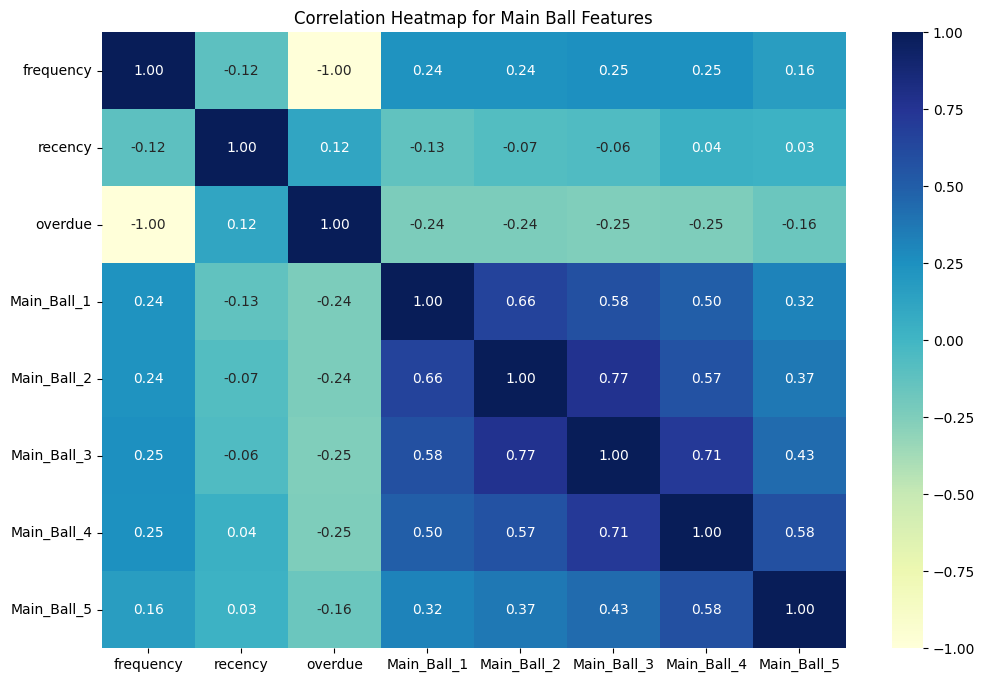

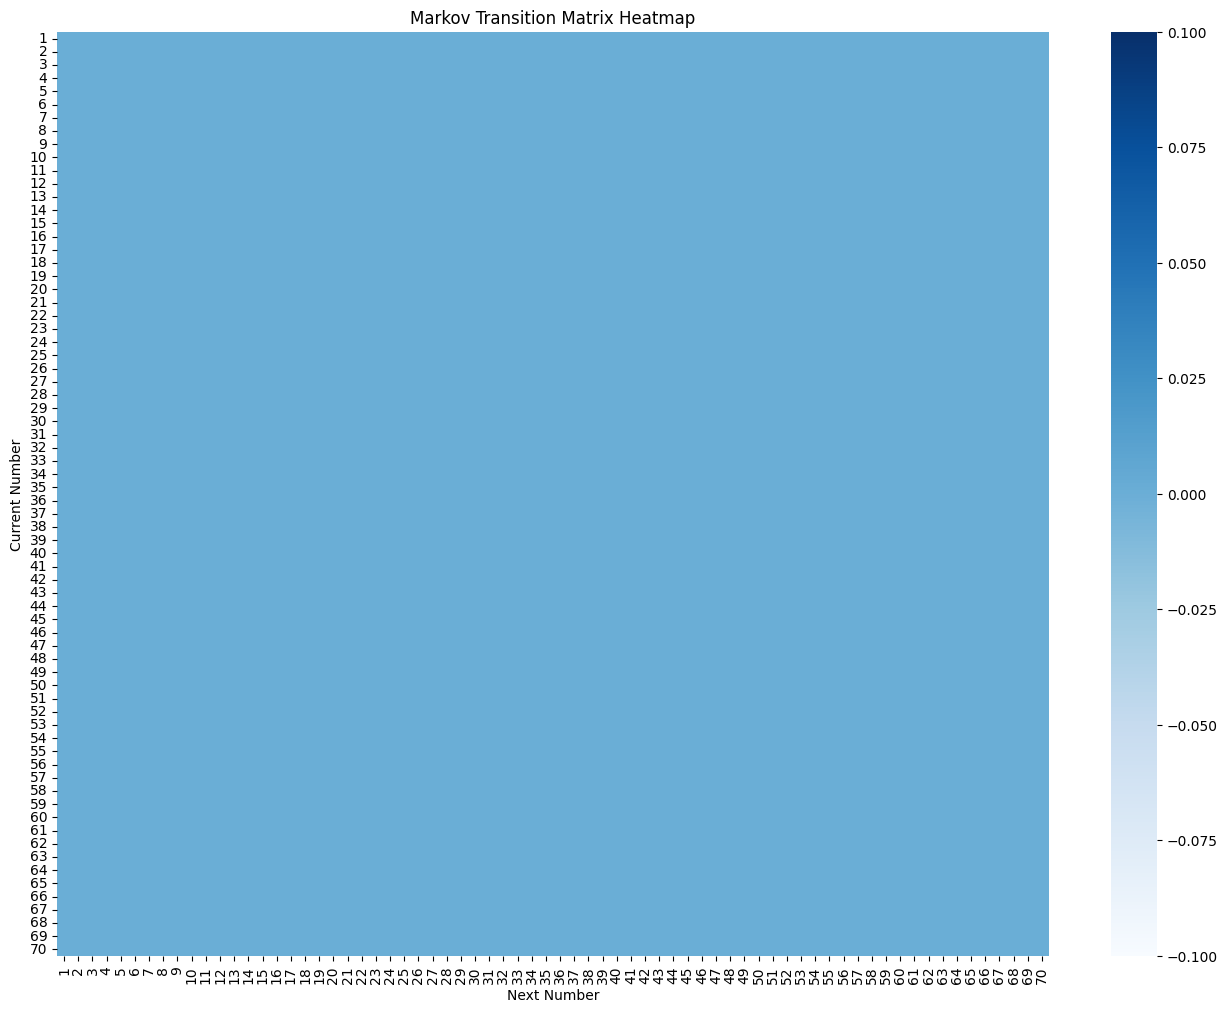

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure main_train is a DataFrame and create column names
main_train_df = pd.DataFrame(main_train, columns=[f'Main_Ball_{i+1}' for i in range(main_train.shape[1])])

# Combine features and target for main balls
main_features_combined = pd.concat([main_ball_features.reset_index(drop=True), main_train_df.reset_index(drop=True)], axis=1)

# Compute correlation matrix
correlation_matrix = main_features_combined.corr()

# Plot heatmap for feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap for Main Ball Features")
plt.show()

# Convert the Markov Chain transition matrix to a DataFrame
# Ensure all numbers from 1 to 70 are represented
transition_df = pd.DataFrame(transition_matrix).fillna(0)

# Add missing rows/columns for numbers not seen in the Markov Chain
all_numbers = range(1, 71)  # Main ball numbers
transition_df = transition_df.reindex(index=all_numbers, columns=all_numbers, fill_value=0)

# Normalize rows to represent probabilities
transition_df = transition_df.div(transition_df.sum(axis=1), axis=0).fillna(0)

# Plot heatmap for Markov Chain transition matrix
plt.figure(figsize=(16, 12))
sns.heatmap(transition_df, cmap="Blues", annot=False, xticklabels=True, yticklabels=True)
plt.title("Markov Transition Matrix Heatmap")
plt.xlabel("Next Number")
plt.ylabel("Current Number")
plt.show()


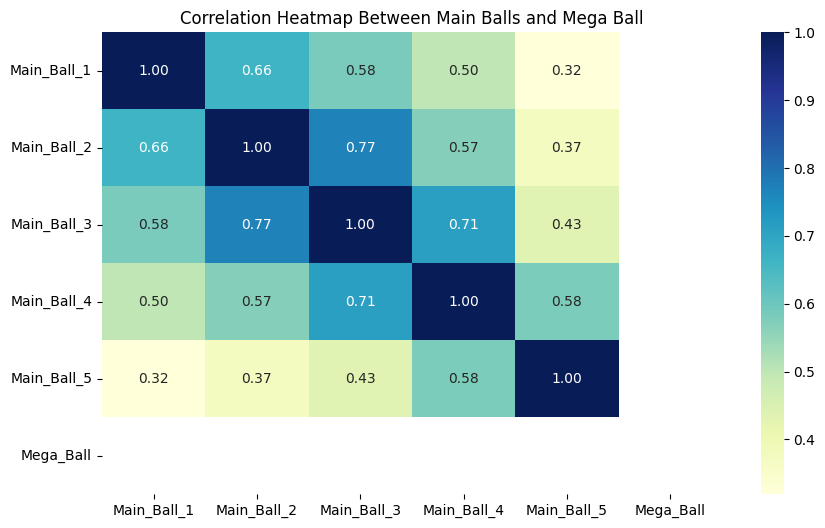

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure main_train and mega_train are DataFrames
main_train_df = pd.DataFrame(main_train, columns=[f'Main_Ball_{i+1}' for i in range(main_train.shape[1])])
mega_train_df = pd.DataFrame(mega_train, columns=['Mega_Ball'])

# Combine main balls and mega ball into a single DataFrame
combined_data = pd.concat([main_train_df, mega_train_df.reset_index(drop=True)], axis=1)

# Compute the correlation matrix
correlation_matrix = combined_data.corr()

# Plot heatmap for correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap Between Main Balls and Mega Ball")
plt.show()
